In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import functions.handy_functions as hf
from functions.parse_data import synth_dataloader

import matplotlib.ticker as mticker


2024-05-07 14:11:30.114165: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-07 14:11:30.148505: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 14:11:30.148526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 14:11:30.149389: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-07 14:11:30.155316: I tensorflow/core/platform/cpu_feature_guar

Initial "Dry" dataset:

In [2]:
#Read data and name columns
df = synth_dataloader(path_name='SMHIdata2',drop_cols=False)
#Dumb down surfaces
df=hf.dumb_down_surface(df)
df.head()

,Cloud_B01,Cloud_B02,Cloud_B03,Cloud_B04,Cloud_B05,Cloud_B06,Cloud_B07,Cloud_B08,Cloud_B08A,Cloud_B09,...,Sat_Zenith_Angle,Sun_Zenith_Angle,Azimuth_Diff_Angle,COT,Cloud_Type,Profile_ID,GOT,Water_Vapor,Surface_Desc,Surface_Desc_Dumb
0,0.95937,0.94195,0.87799,0.92936,0.93407,0.95181,0.96217,0.92871,0.97181,0.49957,...,4.53,52.05,167.66,5.897,3,3335,0.126,0.35,water-snow-mediumgranular,frost/snow
1,0.28649,0.30422,0.40100,0.27834,0.57800,1.01964,1.02787,1.00519,1.03599,0.59139,...,12.85,41.68,161.91,1.275,2,1996,0.126,0.31,vegetation-tree-pinus,vegetation
2,0.30657,0.28715,0.25066,0.30366,0.29214,0.34088,0.40079,0.37376,0.48750,0.02092,...,14.53,79.23,168.52,1.799,1,6796,0.127,4.04,soil-mollisol-haplaquoll,soil
3,0.27930,0.27146,0.33719,0.19841,0.46411,0.88787,0.89584,0.87746,0.90439,0.51811,...,6.54,70.23,165.49,0.519,2,3701,0.123,0.22,vegetation-tree-abies,vegetation
4,0.42411,0.39689,0.38594,0.32623,0.37338,0.60678,0.66895,0.55343,0.70168,0.01513,...,8.56,75.15,148.48,8.569,2,6345,0.128,5.40,vegetation-shrub-baccharis,vegetation


In [3]:
clearcols = ['Clear_B02','Clear_B03','Clear_B04','Clear_B05','Clear_B06',
             'Clear_B07','Clear_B08','Clear_B08A','Clear_B09','Clear_B10','Clear_B11','Clear_B12']
cloudcols = ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
             'Cloud_B07','Cloud_B08','Cloud_B08A','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12']

In [4]:
#Find cloudy/input means:
print('Clody means:')
print(np.mean(df[cloudcols].to_numpy(),axis=0))
print(np.mean(df['Sun_Zenith_Angle']))
#Find cloudy/input stds:
print('Cloudy stds:')
print(np.std(df[cloudcols].to_numpy(),axis=0))
print(np.std(df['Sun_Zenith_Angle']))

Clody means:
[0.53495759 0.53831727 0.53299159 0.62973687 0.82688529 0.85930602
 0.80338501 0.88032092 0.4081777  0.06656548 0.42824127 0.30130615]
58.07626624999999
Cloudy stds:
[0.21896173 0.18874651 0.23651405 0.18575128 0.1694918  0.17001166
 0.16244848 0.17179307 0.23768355 0.09690765 0.30990253 0.20258604]
15.60208150993357


In [5]:
#Find total amount of surface types
unique_surf_all, count_surf_all = np.unique(np.array(df['Surface_Desc']), return_counts=True)
print(len(unique_surf_all))

139


In [6]:
#Find mean of all clear data
means = np.mean(np.array(df[clearcols]),axis=0)
#Find rates of each surf type
surfs_all=np.array(df['Surface_Desc_Dumb'])
unique_surf, count_surf = np.unique(surfs_all, return_counts=True)

#Find stds, and deviations from average, of each surf type
for i in range(len(unique_surf)):
    print(unique_surf[i]+': '+str(count_surf[i])+' = '+str(count_surf[i]*100/sum(count_surf))+'%')
    surf_data = np.array(df[df['Surface_Desc_Dumb']==unique_surf[i]][clearcols])
    std = np.mean(np.std(surf_data,axis=0))
    print('with std: '+str(std))

frost/snow: 7691 = 3.8455%
with std: 0.12086247052622184
nonphotosyntheticvegetation: 15594 = 7.797%
with std: 0.17050875661508383
rock: 21008 = 10.504%
with std: 0.23845628063509214
soil: 10533 = 5.2665%
with std: 0.17342601519111986
vegetation: 141346 = 70.673%
with std: 0.1093317573250767
water/ice: 3828 = 1.914%
with std: 0.013640856684076892


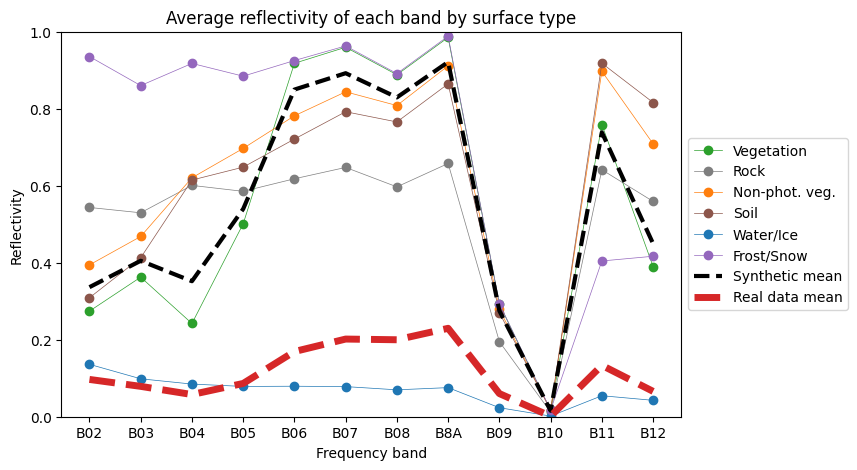

In [7]:
#Decide whether to include real mean
include_real=True

#Find surface types
surfs = ['vegetation','rock','nonphotosyntheticvegetation','soil','water/ice','frost/snow']
surf_titles=['Vegetation','Rock','Non-phot. veg.','Soil','Water/Ice','Frost/Snow','Synthetic mean']

#Find mean reflectivities of each non-water surf type
surf_means=np.zeros([len(surfs),len(clearcols)])
for i in range(len(surfs)):
    surf_means[i,:]=np.mean(df[df['Surface_Desc_Dumb']==surfs[i]][clearcols],axis=0)

#Find total mean
total_mean=np.mean(df[clearcols],axis=0)
total_std=np.std(df[clearcols],axis=0)

#Import Real images mean
if include_real:
    real_ex_mean=[0.09684203, 0.07886069, 0.05764359, 0.08644165, 0.16928667, 0.20171528, 0.19991286, 0.2296261 , 0.06008771, 0.00132, 0.13342121, 0.06587758]

#Print deviations
x=np.arange(len(clearcols))
plt.rcParams['figure.figsize'] = [8,5]
plt.figure()
plt.plot(x,surf_means[0,:].flatten(),'-o',linewidth=0.5,c='tab:green')
plt.plot(x,surf_means[1,:].flatten(),'-o',linewidth=0.5,c='tab:gray')
plt.plot(x,surf_means[2,:].flatten(),'-o',linewidth=0.5,c='tab:orange')
plt.plot(x,surf_means[3,:].flatten(),'-o',linewidth=0.5,c='tab:brown')
plt.plot(x,surf_means[4,:].flatten(),'-o',linewidth=0.5,c='tab:blue')
plt.plot(x,surf_means[5,:].flatten(),'-o',linewidth=0.5,c='tab:purple')

plt.plot(x,total_mean,'--',c='black',linewidth=3.0)
if include_real:
    plt.plot(x,real_ex_mean,'--',c='tab:red',linewidth=5.0)

plt.xticks(x, ['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
plt.title('Average reflectivity of each band by surface type')
plt.xlabel('Frequency band')
plt.ylabel('Reflectivity')
# Put a legend to the right of the current axis
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
if include_real:
   plt.legend(['Vegetation','Rock','Non-phot. veg.','Soil','Water/Ice','Frost/Snow','Synthetic mean', 'Real data mean'],loc='center left',bbox_to_anchor=(1, 0.5))
else:
    plt.legend(['Vegetation','Rock','Non-phot. veg.','Soil','Water/Ice','Frost/Snow','Synthetic mean'],loc='center left',bbox_to_anchor=(1, 0.5))
plt.ylim([0, 1])
plt.show()

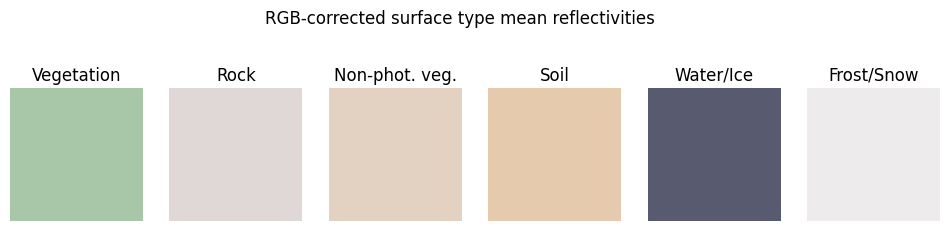

In [8]:
#Display color-corrected versions of surface type means
surf_titles=['Vegetation','Rock','Non-phot. veg.','Soil','Water/Ice','Frost/Snow','Synthetic mean']

#Find means
surf_ims=np.zeros([5,5,3,len(surfs)])
for i in range(len(surfs)):
    surf_ims[:,:,:,i]=hf.Sentinel2TrueColor(np.tile(surf_means[i,:],[5,5,1]))

plt.rcParams['figure.figsize'] = [12, 3]
fig,axs =plt.subplots(ncols=6,nrows=1)
for i in range(len(surfs)):
    axs[i].imshow(surf_ims[:,:,:,i])
    axs[i].title.set_text(surf_titles[i])
    axs[i].set_axis_off()
fig.suptitle('RGB-corrected surface type mean reflectivities')
plt.show()



0: 50000 = 25.0% with mean COT:0.0
1: 9985 = 4.9925% with mean COT:14.261318177265897
2: 9967 = 4.9835% with mean COT:9.595307916123208
3: 10130 = 5.065% with mean COT:18.289357255676208
4: 9859 = 4.9295% with mean COT:24.145905974236737
5: 10059 = 5.0295% with mean COT:8.52705964807635
6: 50000 = 25.0% with mean COT:17.15234794
7: 50000 = 25.0% with mean COT:26.988614199999994


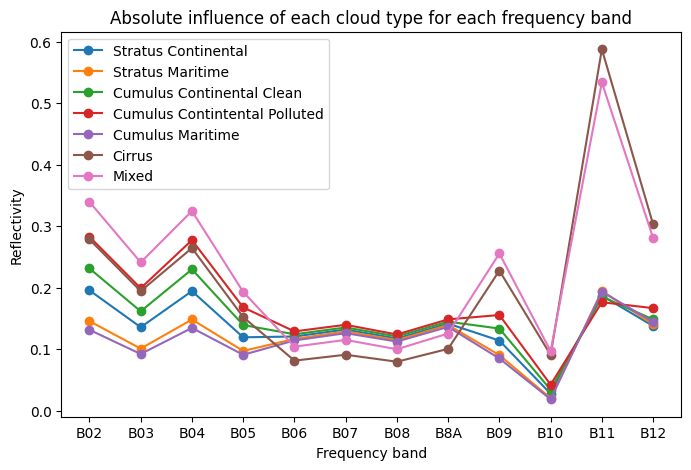

In [15]:
#Find rates of each cloud type, group mixed clouds for clarity
clouds_all=np.array(df['Cloud_Type'])
for i in range(len(clouds_all)):
    if clouds_all[i]>6:
        clouds_all[i]=7
unique_cloud, count_cloud = np.unique(clouds_all, return_counts=True)

#Find influence and COT of each surf type
cloud_inf = np.zeros([len(unique_cloud), len(clearcols)])
for i in range(len(unique_cloud)):
    cloud_data = np.array(df[clouds_all == unique_cloud[i]][cloudcols])-np.array(df[clouds_all == unique_cloud[i]][clearcols])
    cloud_inf[i,:] = np.mean(np.abs(cloud_data),axis=0)
    cloud_COT = np.mean(np.array(df[clouds_all == unique_cloud[i]]['COT']))

    print(str(unique_cloud[i])+': '+str(count_cloud[i])+' = '+str(count_cloud[i]/2000)+'%'+' with mean COT:'+str(cloud_COT))

plt.rcParams['figure.figsize'] = [8,5]
plt.figure()
for i in range(1,len(unique_cloud)):
    plt.plot(x,cloud_inf[i,:],'-o')

plt.xticks(x, ['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
plt.title('Absolute influence of each cloud type for each frequency band')
plt.xlabel('Frequency band')
plt.ylabel('Reflectivity')
plt.legend(['Stratus Continental','Stratus Maritime','Cumulus Continental Clean','Cumulus Contintental Polluted','Cumulus Maritime','Cirrus','Mixed'],loc='upper left')
ax = plt.gca()
#ax.set_ylim([-0.6, 0.4])
plt.show()

0: 50000 = 84.9199205149544%
1: 886 = 1.504780991524992%
2: 1156 = 1.9633485623057456%
3: 685 = 1.1634029110548751%
4: 529 = 0.8984527590482175%
5: 1339 = 2.2741554713904786%
6: 3400 = 5.774554595016899%
7: 884 = 1.5013841947043938%


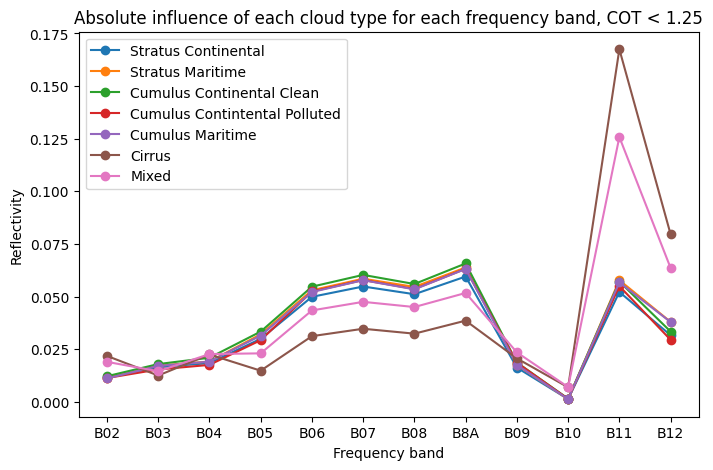

In [16]:
#Now do the same for COT < 3.6
df_thin=df.loc[df['COT']<1.25]

#Find rates of each cloud type, group mixed clouds for clarity
clouds_all=np.array(df_thin['Cloud_Type'])
for i in range(len(clouds_all)):
    if clouds_all[i]>6:
        clouds_all[i]=7
unique_cloud, count_cloud = np.unique(clouds_all, return_counts=True)

#Find influence and COT of each surf type
cloud_inf = np.zeros([len(unique_cloud), len(clearcols)])
for i in range(len(unique_cloud)):
    cloud_data = np.array(df_thin[clouds_all == unique_cloud[i]][cloudcols])-np.array(df_thin[clouds_all == unique_cloud[i]][clearcols])
    cloud_inf[i,:] = np.mean(np.abs(cloud_data),axis=0)
    print(str(unique_cloud[i])+': '+str(count_cloud[i])+' = '+str(count_cloud[i]*100/sum(count_cloud))+'%')

plt.figure()
for i in range(1,len(unique_cloud)):
    plt.plot(x,cloud_inf[i,:],'-o')

plt.xticks(x, ['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
plt.title('Absolute influence of each cloud type for each frequency band, COT < 1.25')
plt.xlabel('Frequency band')
plt.ylabel('Reflectivity')
plt.legend(['Stratus Continental','Stratus Maritime','Cumulus Continental Clean','Cumulus Contintental Polluted','Cumulus Maritime','Cirrus','Mixed'],loc='upper left')
ax = plt.gca()
#ax.set_ylim([-0.6, 0.4])
plt.show()


New, "Wet" dataset:

In [11]:
#Read data and name columns
df_new = synth_dataloader(path_name='SMHIdata2_newsurf',drop_cols=False)
#Dumb down surfaces
df_new=hf.dumb_down_surface(df_new)
df_new.head()


,Cloud_B01,Cloud_B02,Cloud_B03,Cloud_B04,Cloud_B05,Cloud_B06,Cloud_B07,Cloud_B08,Cloud_B08A,Cloud_B09,...,Sat_Zenith_Angle,Sun_Zenith_Angle,Azimuth_Diff_Angle,COT,Cloud_Type,Profile_ID,GOT,Water_Vapor,Surface_Desc,Surface_Desc_Dumb
0,0.60724,0.57804,0.51792,0.54680,0.56000,0.56824,0.57365,0.56583,0.57950,0.37962,...,9.00,68.68,48.59,25.181,3,9543,0.122,0.56,water-ice-none,water/ice
1,0.31841,0.28975,0.25479,0.29171,0.32868,0.40295,0.44817,0.45809,0.50999,0.17019,...,1.60,73.05,176.23,1.730,2,3672,0.116,0.77,water-ice-none,water/ice
2,0.71682,0.71170,0.68907,0.73376,0.76922,0.81416,0.83261,0.83383,0.85262,0.63399,...,14.75,42.45,16.45,20.746,4,3564,0.124,0.23,water-ice-none,water/ice
3,0.29679,0.30316,0.32260,0.39997,0.43564,0.48821,0.52882,0.53207,0.58302,0.22735,...,7.49,55.96,96.60,0.721,1,2993,0.122,0.83,water-ice-none,water/ice
4,0.86300,0.84968,0.80047,0.83504,0.80686,0.83849,0.86902,0.80830,0.88989,0.26912,...,1.45,51.76,79.44,49.984,3,6226,0.127,4.57,water-ice-none,water/ice


In [12]:
#Lost Surface information
print(np.unique(df_new['Surface_Desc'].to_numpy()))

['water-frost-none' 'water-ice-none' 'water-snow-coarsegranular'
 'water-snow-finegranular' 'water-snow-mediumgranular'
 'water-tapwater-none']


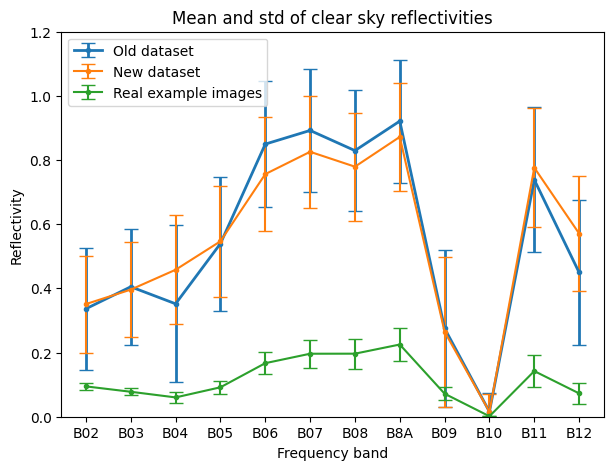

0.05467
0.06088


In [13]:
#Find total mean
total_mean_new=np.mean(df_new[clearcols],axis=0)
total_std_new=np.std(df_new[clearcols],axis=0)

#Import example image means/stds
real_ex_mean=[0.09453778, 0.0777872 , 0.06017147, 0.09173835, 0.16690802, 0.19634993, 0.19650194, 0.22506709, 0.0717202 , 0.00139894, 0.14225991, 0.07273129]
real_ex_std=[0.01178028, 0.01023469, 0.01787003, 0.02111118, 0.03498968, 0.04356319, 0.04683061, 0.05012912, 0.02070586, 0.00046948, 0.05076208, 0.03225045]

#Print means
x=np.arange(len(clearcols))
plt.rcParams['figure.figsize'] = [7,5]
plt.figure()

plt.errorbar(x,total_mean,yerr=total_std,linewidth=2,marker='.', capsize=5)
plt.errorbar(x,total_mean_new,yerr=total_std_new,marker='.', capsize=5)
plt.errorbar(x,real_ex_mean,yerr=real_ex_std,marker='.', capsize=5)

plt.xticks(x, ['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
plt.title('Mean and std of clear sky reflectivities')
plt.xlabel('Frequency band')
plt.ylabel('Reflectivity')
plt.legend(['Old dataset','New dataset','Real example images'],loc='upper left')
ax = plt.gca()
ax.set_ylim([0, 1.2])
plt.show()

print(min(df['Clear_B04']))
print(min(df_new['Clear_B04']))

0: 50000 = 25.0% with mean COT:0.0
1: 9947 = 4.9735% with mean COT:14.112264300794209
2: 10026 = 5.013% with mean COT:9.62576700578496
3: 10096 = 5.048% with mean COT:18.070454140253567
4: 9909 = 4.9545% with mean COT:24.3968747603189
5: 10022 = 5.011% with mean COT:8.63048573139094
6: 50000 = 25.0% with mean COT:17.101529859999996
7: 50000 = 25.0% with mean COT:26.88455312


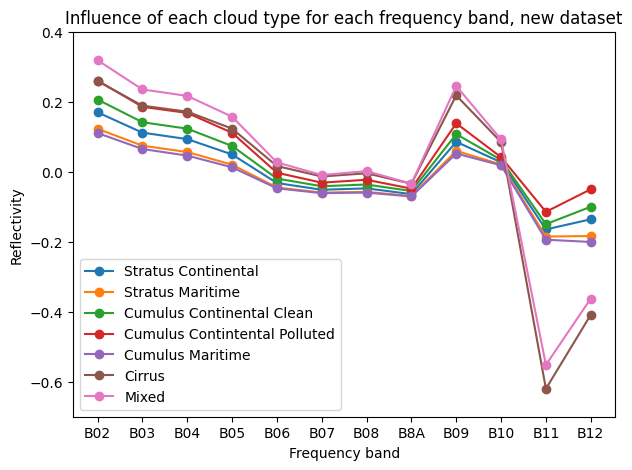

In [14]:
#Find rates of each cloud type, group mixed clouds for clarity
clouds_all=np.array(df_new['Cloud_Type'])
for i in range(len(clouds_all)):
    if clouds_all[i]>6:
        clouds_all[i]=7
unique_cloud, count_cloud = np.unique(clouds_all, return_counts=True)

#Find influence and COT of each surf type
cloud_inf = np.zeros([len(unique_cloud), len(clearcols)])
for i in range(len(unique_cloud)):
    cloud_data = np.array(df_new[clouds_all == unique_cloud[i]][cloudcols])-np.array(df_new[clouds_all == unique_cloud[i]][clearcols])
    cloud_inf[i,:] = np.mean(cloud_data,axis=0)
    cloud_COT = np.mean(np.array(df_new[clouds_all == unique_cloud[i]]['COT']))

    print(str(unique_cloud[i])+': '+str(count_cloud[i])+' = '+str(count_cloud[i]/2000)+'%'+' with mean COT:'+str(cloud_COT))

plt.figure()
for i in range(1,len(unique_cloud)):
    plt.plot(x,cloud_inf[i,:],'-o')

plt.xticks(x, ['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
plt.title('Influence of each cloud type for each frequency band, new dataset')
plt.xlabel('Frequency band')
plt.ylabel('Reflectivity')
plt.legend(['Stratus Continental','Stratus Maritime','Cumulus Continental Clean','Cumulus Contintental Polluted','Cumulus Maritime','Cirrus','Mixed'],loc='lower left')
ax = plt.gca()
ax.set_ylim([-0.7, 0.4])
plt.show()

Synth data smackdown:

[0.03936 0.02167 0.05467 0.05467 0.05629 0.05809 0.04927 0.05704 0.00333
 0.00021 0.0372  0.01358]


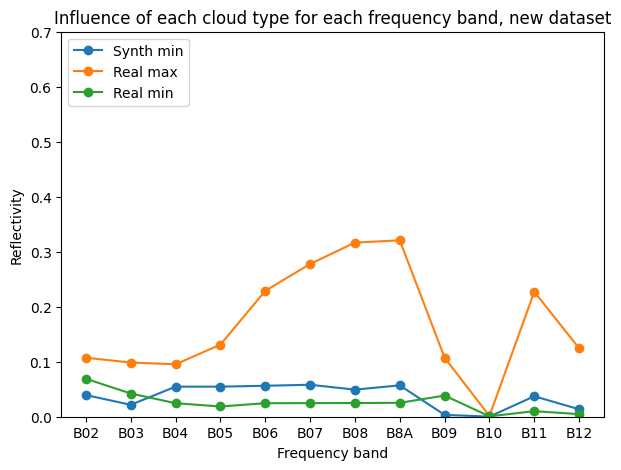

In [15]:
df_new_min = df_new[clearcols].to_numpy().min(axis=0)
df_min = df[clearcols].to_numpy().min(axis=0)
min_min = np.minimum(df_new_min,df_min)

print(min_min)

realmax=[0.1073, 0.0985, 0.0953, 0.1311, 0.2289, 0.2777, 0.3166, 0.3207, 0.1073, 0.0013, 0.2272, 0.1244]
realmin=[0.069,  0.0422, 0.0246, 0.0186, 0.0246, 0.0247, 0.0249, 0.0253, 0.0385, 0.0007, 0.0101, 0.0047]

plt.figure()
plt.plot(x,min_min,'-o')
plt.plot(x,realmax,'-o')
plt.plot(x,realmin,'-o')

plt.xticks(x, ['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
plt.title('Influence of each cloud type for each frequency band, new dataset')
plt.xlabel('Frequency band')
plt.ylabel('Reflectivity')
plt.legend(['Synth min','Real max','Real min'],loc='upper left')
ax = plt.gca()
ax.set_ylim([0, 0.7])
plt.show()

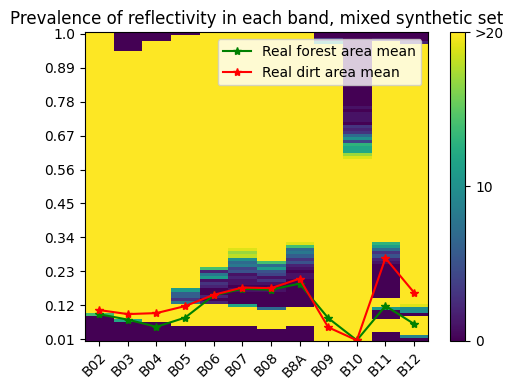

In [16]:
#Create heatmap of reflectivity prevalence

bins = 100
ref_prev = np.zeros([bins,len(clearcols)])
binlims = np.histogram(df_new[clearcols],bins=bins,range=(0,np.max(df_new[clearcols])))[1]
bincent = np.zeros(bins)
for i in range(bins):
    bincent[i]=(binlims[i]+binlims[i+1])/2

for j in range(len(clearcols)):
    ref_prev[:,j]= np.histogram(df_new[clearcols[j]],bins=bins,range=(0,np.max(df_new[clearcols])))[0]

forestmeans = [0.0855725,0.06806225,0.044694,0.07437575,0.14659775,0.16814375,0.16502925,0.184828,0.073099,0.000995,0.11263325,0.05405875]
dirtmeans = [0.099022,0.0859425,0.089176,0.1118155,0.148396,0.172073,0.170041,0.200777,0.0432235,0.0009865,0.267628,0.1557145]
y=np.round(np.linspace(bincent[0],bincent[-1],10),2)
y_loc=np.linspace(0,bins-1,len(y))

plt.rcParams['figure.figsize'] = [5,4]

fig, ax = plt.subplots()
im = ax.imshow(ref_prev,aspect='auto',vmax=20,origin='lower')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(clearcols)), labels=['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
ax.set_yticks(y_loc, labels=y)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


ax.set_title("Prevalence of reflectivity in each band, mixed synthetic set")
fig.tight_layout()
#fig.colorbar(im)
fig.colorbar(im,
            ticks=[0,10,20],
            format=mticker.FixedFormatter(['0', '10', '>20'])
            )
plt.plot(np.arange(0,len(clearcols)),bins*(np.array(forestmeans)-min(bincent)),'-*',c='green')
plt.plot(np.arange(0,len(clearcols)),bins*(np.array(dirtmeans)-min(bincent)),'-*',c='red')
plt.legend(['Real forest area mean','Real dirt area mean'])
plt.show()

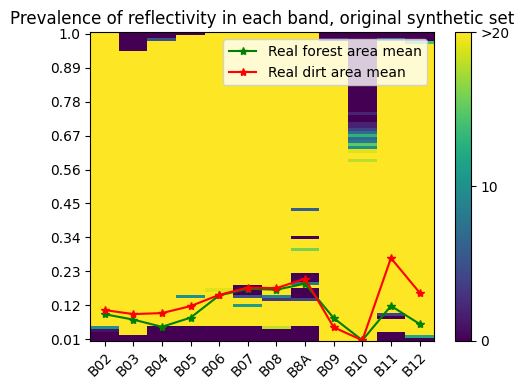

In [17]:
#Create heatmap of reflectivity prevalence

bins = 100
ref_prev = np.zeros([bins,len(clearcols)])
binlims = np.histogram(df[clearcols],bins=bins,range=(0,np.max(df[clearcols])))[1]
bincent = np.zeros(bins)
for i in range(bins):
    bincent[i]=(binlims[i]+binlims[i+1])/2

for j in range(len(clearcols)):
    ref_prev[:,j]= np.histogram(df[clearcols[j]],bins=bins,range=(0,np.max(df[clearcols])))[0]

forestmeans = [0.0855725,0.06806225,0.044694,0.07437575,0.14659775,0.16814375,0.16502925,0.184828,0.073099,0.000995,0.11263325,0.05405875]
dirtmeans = [0.099022,0.0859425,0.089176,0.1118155,0.148396,0.172073,0.170041,0.200777,0.0432235,0.0009865,0.267628,0.1557145]
y=np.round(np.linspace(bincent[0],bincent[-1],10),2)
y_loc=np.linspace(0,bins-1,len(y))

plt.rcParams['figure.figsize'] = [5,4]

fig, ax = plt.subplots()
im = ax.imshow(ref_prev,aspect='auto',vmax=20,origin='lower')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(clearcols)), labels=['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
ax.set_yticks(y_loc, labels=y)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


ax.set_title("Prevalence of reflectivity in each band, original synthetic set")
fig.tight_layout()
#fig.colorbar(im)
fig.colorbar(im,
            ticks=[0,10,20],
            format=mticker.FixedFormatter(['0', '10', '>20'])
            )
plt.plot(np.arange(0,len(clearcols)),bins*(np.array(forestmeans)-min(bincent)),'-*',c='green')
plt.plot(np.arange(0,len(clearcols)),bins*(np.array(dirtmeans)-min(bincent)),'-*',c='red')
plt.legend(['Real forest area mean','Real dirt area mean'])
plt.show()

Text(0.5, 0.98, 'Real surface area means and closest synthetic points.')

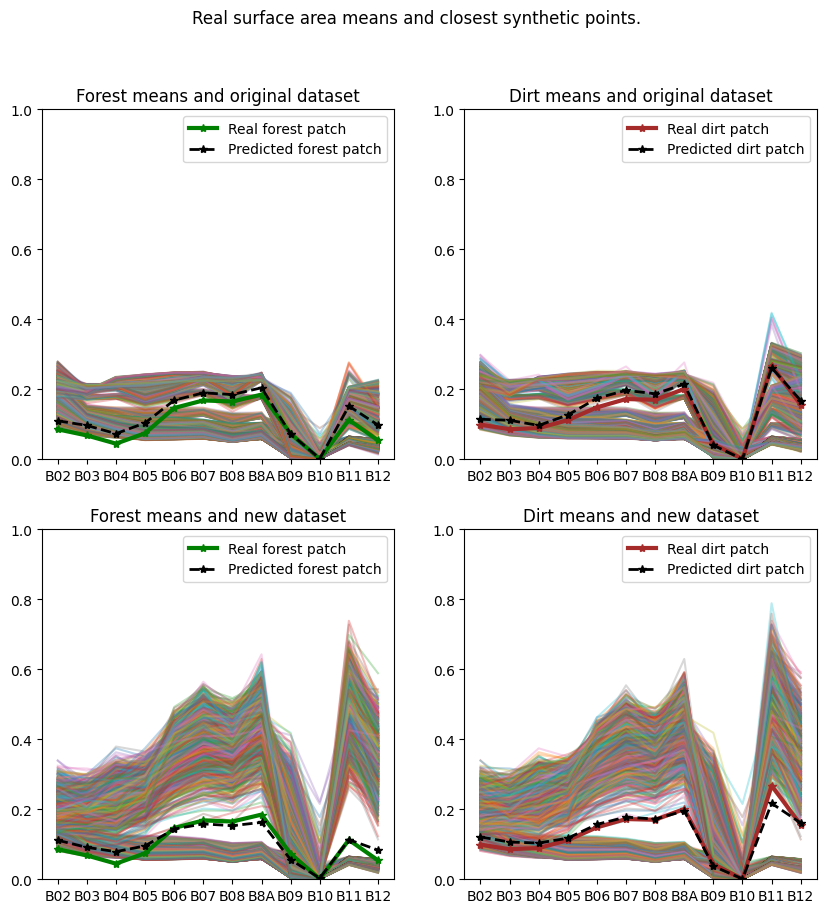

In [18]:
#Import patch predictions, old dataset:
Forest_preds_old=[0.11001666, 0.09662003, 0.0732337,  0.10387617, 0.16865307, 0.18978842, 0.18490576, 0.20431197, 0.07241825, 0.00194413, 0.15211078, 0.09791404]
Dirt_preds_old=[0.11436171, 0.11138776, 0.09664196, 0.12658355, 0.17415888, 0.19701536, 0.18718583, 0.21439514, 0.04000911, 0.00050668, 0.26177064, 0.16768661]

Forest_preds_new=[0.11135727, 0.09119365, 0.07893981, 0.0954012, 0.14354457, 0.1582161, 0.15311121, 0.16261103, 0.05604368, 0.00303396, 0.11319081, 0.08337622]
Dirt_preds_new=[0.1209812, 0.10634011, 0.10360773, 0.11748342, 0.15698459, 0.17781312, 0.17179467, 0.19533543, 0.03737868, 0.00116572, 0.21710739, 0.16093441]
no_neigh = 5000

#Find closest (euclidean) rows, old dataset, forest
diff_df_for_old = df[clearcols] - forestmeans
norm_df_for_old = diff_df_for_old.apply(np.linalg.norm, axis=1)
closeidx_for_old = np.argsort(norm_df_for_old.to_numpy())
closest_for_old = df[clearcols].iloc[closeidx_for_old[0:no_neigh]]

#Find closest (euclidean) rows, old dataset, dirt
diff_df_dir_old = df[clearcols] - dirtmeans
norm_df_dir_old = diff_df_dir_old.apply(np.linalg.norm, axis=1)
closeidx_dir_old = np.argsort(norm_df_dir_old.to_numpy())
closest_dir_old = df[clearcols].iloc[closeidx_dir_old[0:no_neigh]]


#Find closest (euclidean) rows, new dataset, forest
diff_df_for_new = df_new[clearcols] - forestmeans
norm_df_for_new = diff_df_for_new.apply(np.linalg.norm, axis=1)
closeidx_for_new = np.argsort(norm_df_for_new.to_numpy())
closest_for_new = df_new[clearcols].iloc[closeidx_for_new[0:no_neigh]]

#Find closest (euclidean) rows, old dataset, dirt
diff_df_dir_new = df_new[clearcols] - dirtmeans
norm_df_dir_new = diff_df_dir_new.apply(np.linalg.norm, axis=1)
closeidx_dir_new = np.argsort(norm_df_dir_new.to_numpy())
closest_dir_new = df_new[clearcols].iloc[closeidx_dir_new[0:no_neigh]]

ncols=2
nrows=2
plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig, axs = plt.subplots(ncols=ncols,nrows=nrows)


for i in range(no_neigh):
    axs[0,0].plot(np.arange(0,len(clearcols)),closest_for_old.to_numpy()[i,:],label='_nolegend_',alpha=0.3)
    axs[0,1].plot(np.arange(0,len(clearcols)),closest_dir_old.to_numpy()[i,:],label='_nolegend_',alpha=0.3)
    axs[1,0].plot(np.arange(0,len(clearcols)),closest_for_new.to_numpy()[i,:],label='_nolegend_',alpha=0.3)
    axs[1,1].plot(np.arange(0,len(clearcols)),closest_dir_new.to_numpy()[i,:],label='_nolegend_',alpha=0.3)

axs[0,0].plot(np.arange(0,len(clearcols)),forestmeans,'-*',c='green',linewidth=3.0,label='Real forest patch')
axs[0,0].plot(np.arange(0,len(clearcols)),Forest_preds_old,'--*',c='black',linewidth=2.0,label='Predicted forest patch')
axs[0,0].set_title('Forest means and original dataset')
axs[0,0].set_ylim([0, 1])
axs[0,0].set_xticks(np.arange(len(clearcols)), labels=['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
axs[0,0].legend()
axs[0,1].plot(np.arange(0,len(clearcols)),dirtmeans,'-*',c='brown',linewidth=3.0,label='Real dirt patch')
axs[0,1].plot(np.arange(0,len(clearcols)),Dirt_preds_old,'--*',c='black',linewidth=2.0,label='Predicted dirt patch')
axs[0,1].set_title('Dirt means and original dataset')
axs[0,1].set_ylim([0, 1])
axs[0,1].set_xticks(np.arange(len(clearcols)), labels=['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
axs[0,1].legend()
axs[1,0].plot(np.arange(0,len(clearcols)),forestmeans,'-*',c='green',linewidth=3.0,label='Real forest patch')
axs[1,0].plot(np.arange(0,len(clearcols)),Forest_preds_new,'--*',c='black',linewidth=2.0,label='Predicted forest patch')
axs[1,0].set_title('Forest means and new dataset')
axs[1,0].set_ylim([0, 1])
axs[1,0].set_xticks(np.arange(len(clearcols)), labels=['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
axs[1,0].legend()
axs[1,1].plot(np.arange(0,len(clearcols)),dirtmeans,'-*',c='brown',linewidth=3.0,label='Real dirt patch')
axs[1,1].plot(np.arange(0,len(clearcols)),Dirt_preds_new,'--*',c='black',linewidth=2.0,label='Predicted dirt patch')
axs[1,1].set_title('Dirt means and new dataset')
axs[1,1].set_ylim([0, 1])
axs[1,1].set_xticks(np.arange(len(clearcols)), labels=['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
axs[1,1].legend()

fig.suptitle('Real surface area means and closest synthetic points.')

New, new dataset:

In [19]:
#Read data and name columns
df_new_new = synth_dataloader(path_name='SMHIdata3_newsurf',drop_cols=False)
#Dumb down surfaces
df_new_new=hf.dumb_down_surface(df_new_new)
df_new_new.head()

,Cloud_B01,Cloud_B02,Cloud_B03,Cloud_B04,Cloud_B05,Cloud_B06,Cloud_B07,Cloud_B08,Cloud_B08A,Cloud_B09,...,Sat_Zenith_Angle,Sun_Zenith_Angle,Azimuth_Diff_Angle,COT,Cloud_Type,Profile_ID,GOT,Water_Vapor,Surface_Desc,Surface_Desc_Dumb
0,0.92072,0.90032,0.81937,0.88448,0.89139,0.91441,0.92868,0.89153,0.94145,0.38836,...,14.16,68.38,17.39,0.383,3,642,0.127,0.49,water-snow-finegranular,frost/snow
1,0.52169,0.50882,0.48280,0.50241,0.50951,0.53268,0.55200,0.53915,0.57368,0.38162,...,14.46,48.11,134.05,11.760,2,5325,0.129,4.86,Mixed,Mixed
2,0.29940,0.29507,0.30924,0.39888,0.47970,0.70832,0.80920,0.78422,0.88195,0.24766,...,4.06,62.25,110.10,2.322,3,472,0.124,1.17,Mixed,Mixed
3,0.51401,0.49327,0.45420,0.47264,0.47603,0.54040,0.57843,0.53577,0.60191,0.17078,...,11.69,67.75,171.25,14.460,1,9224,0.124,6.23,Mixed,Mixed
4,0.41524,0.42440,0.46368,0.55680,0.66378,0.99693,1.10311,1.06547,1.11276,0.51378,...,2.06,31.39,60.48,4.085,5,51,0.099,0.75,Mixed,Mixed


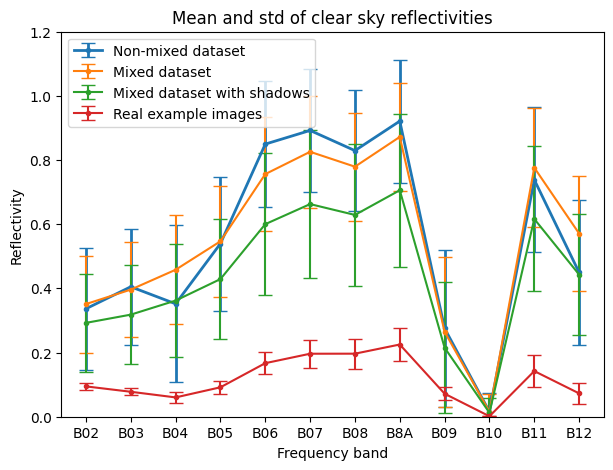

0.05467
0.06088
0.0474


In [20]:
#Find total mean
total_mean_new_new=np.mean(df_new_new[clearcols],axis=0)
total_std_new_new=np.std(df_new_new[clearcols],axis=0)

#Import example image means/stds
real_ex_mean=[0.09453778, 0.0777872 , 0.06017147, 0.09173835, 0.16690802, 0.19634993, 0.19650194, 0.22506709, 0.0717202 , 0.00139894, 0.14225991, 0.07273129]
real_ex_std=[0.01178028, 0.01023469, 0.01787003, 0.02111118, 0.03498968, 0.04356319, 0.04683061, 0.05012912, 0.02070586, 0.00046948, 0.05076208, 0.03225045]

#Print means
x=np.arange(len(clearcols))
plt.rcParams['figure.figsize'] = [7,5]
plt.figure()

plt.errorbar(x,total_mean,yerr=total_std,linewidth=2,marker='.', capsize=5)
plt.errorbar(x,total_mean_new,yerr=total_std_new,marker='.', capsize=5)
plt.errorbar(x,total_mean_new_new,yerr=total_std_new_new,marker='.', capsize=5)
plt.errorbar(x,real_ex_mean,yerr=real_ex_std,marker='.', capsize=5)

plt.xticks(x, ['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
plt.title('Mean and std of clear sky reflectivities')
plt.xlabel('Frequency band')
plt.ylabel('Reflectivity')
plt.legend(['Non-mixed dataset','Mixed dataset','Mixed dataset with shadows','Real example images'],loc='upper left')
ax = plt.gca()
ax.set_ylim([0, 1.2])
plt.show()

print(min(df['Clear_B04']))
print(min(df_new['Clear_B04']))
print(min(df_new_new['Clear_B04']))

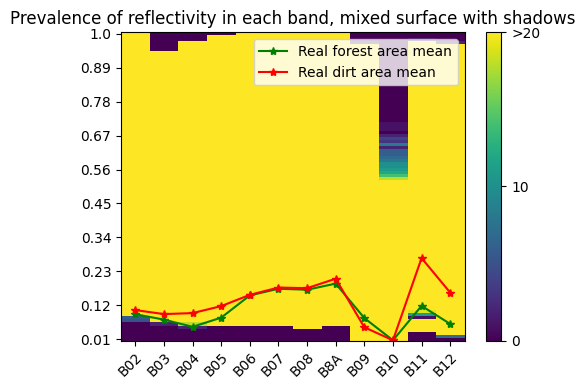

In [23]:
#Create heatmap of reflectivity prevalence

bins = 100
ref_prev = np.zeros([bins,len(clearcols)])
binlims = np.histogram(df_new_new[clearcols],bins=bins,range=(0,np.max(df_new_new[clearcols])))[1]
bincent = np.zeros(bins)
for i in range(bins):
    bincent[i]=(binlims[i]+binlims[i+1])/2

for j in range(len(clearcols)):
    ref_prev[:,j]= np.histogram(df_new_new[clearcols[j]],bins=bins,range=(0,np.max(df_new_new[clearcols])))[0]

forestmeans = [0.0855725,0.06806225,0.044694,0.07437575,0.14659775,0.16814375,0.16502925,0.184828,0.073099,0.000995,0.11263325,0.05405875]
dirtmeans = [0.099022,0.0859425,0.089176,0.1118155,0.148396,0.172073,0.170041,0.200777,0.0432235,0.0009865,0.267628,0.1557145]
y=np.round(np.linspace(bincent[0],bincent[-1],10),2)
y_loc=np.linspace(0,bins-1,len(y))

plt.rcParams['figure.figsize'] = [5,4]

fig, ax = plt.subplots()
im = ax.imshow(ref_prev,aspect='auto',vmax=20,origin='lower')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(clearcols)), labels=['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
ax.set_yticks(y_loc, labels=y)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


ax.set_title("Prevalence of reflectivity in each band, mixed surface with shadows")
fig.tight_layout()
#fig.colorbar(im)
fig.colorbar(im,
            ticks=[0,10,20],
            format=mticker.FixedFormatter(['0', '10', '>20'])
            )
plt.plot(np.arange(0,len(clearcols)),bins*(np.array(forestmeans)-min(bincent)),'-*',c='green')
plt.plot(np.arange(0,len(clearcols)),bins*(np.array(dirtmeans)-min(bincent)),'-*',c='red')
plt.legend(['Real forest area mean','Real dirt area mean'])
plt.show()

Text(0.5, 0.98, 'Real surface area means and closest synthetic points.')

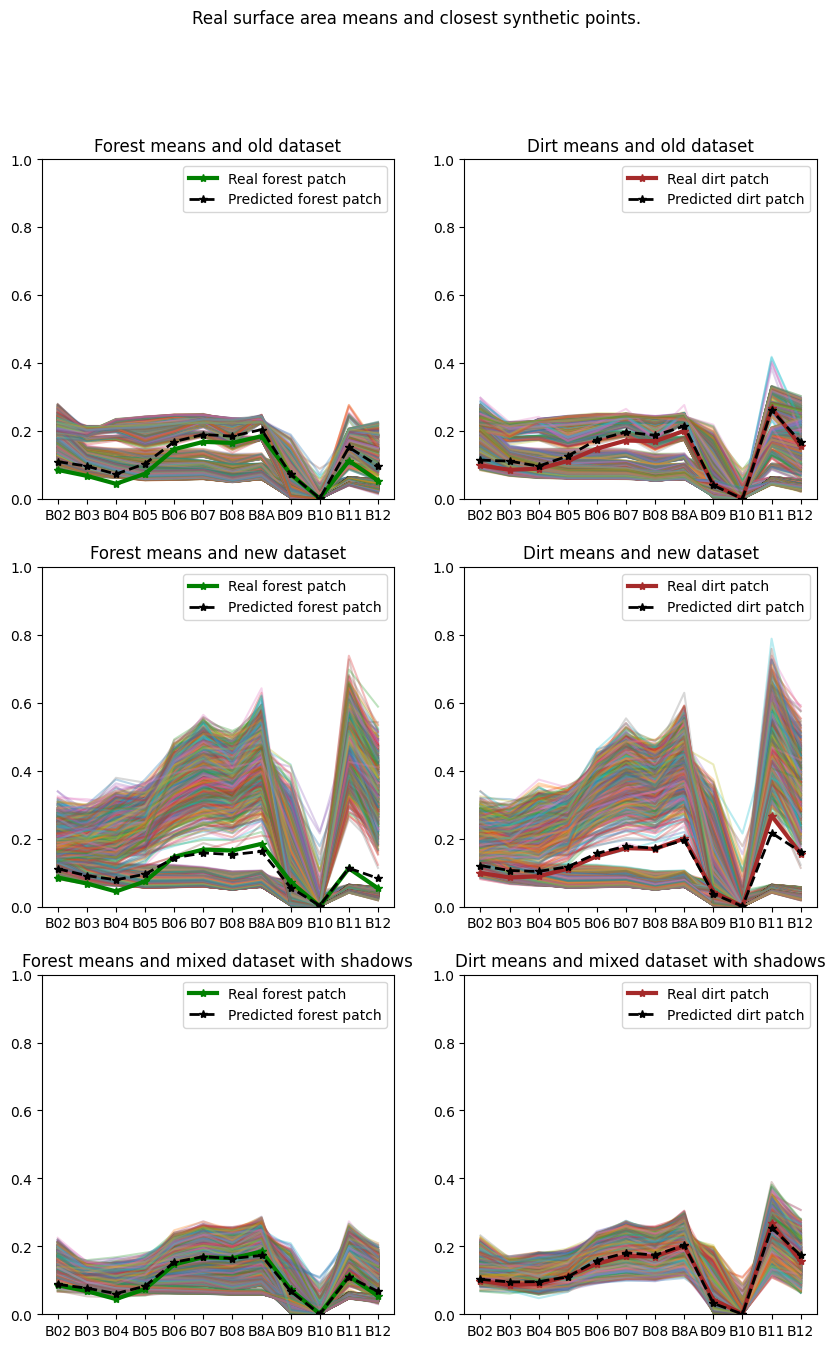

In [25]:
#Import patch predictions, old dataset:
Forest_preds_old=[0.11001666, 0.09662003, 0.0732337,  0.10387617, 0.16865307, 0.18978842, 0.18490576, 0.20431197, 0.07241825, 0.00194413, 0.15211078, 0.09791404]
Dirt_preds_old=[0.11436171, 0.11138776, 0.09664196, 0.12658355, 0.17415888, 0.19701536, 0.18718583, 0.21439514, 0.04000911, 0.00050668, 0.26177064, 0.16768661]

Forest_preds_new=[0.11135727, 0.09119365, 0.07893981, 0.0954012, 0.14354457, 0.1582161, 0.15311121, 0.16261103, 0.05604368, 0.00303396, 0.11319081, 0.08337622]
Dirt_preds_new=[0.1209812, 0.10634011, 0.10360773, 0.11748342, 0.15698459, 0.17781312, 0.17179467, 0.19533543, 0.03737868, 0.00116572, 0.21710739, 0.16093441]

Forest_preds_newnew=[0.08816354, 0.07680883, 0.06091626, 0.08274042, 0.15324952, 0.16966783, 0.16413927, 0.1732719, 0.06774468, 0.0006621, 0.10990744, 0.06719467]
Dirt_preds_newnew=[0.10286517, 0.09510641, 0.09603558, 0.11020315, 0.15817835, 0.1809142, 0.17428675, 0.20342334, 0.03209255, 0.00044747, 0.25474695, 0.17315296]

no_neigh = 5000

#Find closest (euclidean) rows, old dataset, forest
diff_df_for_old = df[clearcols] - forestmeans
norm_df_for_old = diff_df_for_old.apply(np.linalg.norm, axis=1)
closeidx_for_old = np.argsort(norm_df_for_old.to_numpy())
closest_for_old = df[clearcols].iloc[closeidx_for_old[0:no_neigh]]

#Find closest (euclidean) rows, old dataset, dirt
diff_df_dir_old = df[clearcols] - dirtmeans
norm_df_dir_old = diff_df_dir_old.apply(np.linalg.norm, axis=1)
closeidx_dir_old = np.argsort(norm_df_dir_old.to_numpy())
closest_dir_old = df[clearcols].iloc[closeidx_dir_old[0:no_neigh]]


#Find closest (euclidean) rows, new dataset, forest
diff_df_for_new = df_new[clearcols] - forestmeans
norm_df_for_new = diff_df_for_new.apply(np.linalg.norm, axis=1)
closeidx_for_new = np.argsort(norm_df_for_new.to_numpy())
closest_for_new = df_new[clearcols].iloc[closeidx_for_new[0:no_neigh]]

#Find closest (euclidean) rows, old dataset, dirt
diff_df_dir_new = df_new[clearcols] - dirtmeans
norm_df_dir_new = diff_df_dir_new.apply(np.linalg.norm, axis=1)
closeidx_dir_new = np.argsort(norm_df_dir_new.to_numpy())
closest_dir_new = df_new[clearcols].iloc[closeidx_dir_new[0:no_neigh]]

#Find closest (euclidean) rows, new dataset, forest
diff_df_for_new_new = df_new_new[clearcols] - forestmeans
norm_df_for_new_new = diff_df_for_new_new.apply(np.linalg.norm, axis=1)
closeidx_for_new_new = np.argsort(norm_df_for_new_new.to_numpy())
closest_for_new_new = df_new_new[clearcols].iloc[closeidx_for_new_new[0:no_neigh]]

#Find closest (euclidean) rows, old dataset, dirt
diff_df_dir_new_new = df_new_new[clearcols] - dirtmeans
norm_df_dir_new_new = diff_df_dir_new_new.apply(np.linalg.norm, axis=1)
closeidx_dir_new_new = np.argsort(norm_df_dir_new_new.to_numpy())
closest_dir_new_new = df_new_new[clearcols].iloc[closeidx_dir_new_new[0:no_neigh]]

ncols=2
nrows=3
plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig, axs = plt.subplots(ncols=ncols,nrows=nrows)


for i in range(no_neigh):
    axs[0,0].plot(np.arange(0,len(clearcols)),closest_for_old.to_numpy()[i,:],label='_nolegend_',alpha=0.3)
    axs[0,1].plot(np.arange(0,len(clearcols)),closest_dir_old.to_numpy()[i,:],label='_nolegend_',alpha=0.3)
    axs[1,0].plot(np.arange(0,len(clearcols)),closest_for_new.to_numpy()[i,:],label='_nolegend_',alpha=0.3)
    axs[1,1].plot(np.arange(0,len(clearcols)),closest_dir_new.to_numpy()[i,:],label='_nolegend_',alpha=0.3)
    axs[2,0].plot(np.arange(0,len(clearcols)),closest_for_new_new.to_numpy()[i,:],label='_nolegend_',alpha=0.3)
    axs[2,1].plot(np.arange(0,len(clearcols)),closest_dir_new_new.to_numpy()[i,:],label='_nolegend_',alpha=0.3)

axs[0,0].plot(np.arange(0,len(clearcols)),forestmeans,'-*',c='green',linewidth=3.0,label='Real forest patch')
axs[0,0].plot(np.arange(0,len(clearcols)),Forest_preds_old,'--*',c='black',linewidth=2.0,label='Predicted forest patch')
axs[0,0].set_title('Forest means and old dataset')
axs[0,0].set_ylim([0, 1])
axs[0,0].set_xticks(np.arange(len(clearcols)), labels=['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
axs[0,0].legend()
axs[0,1].plot(np.arange(0,len(clearcols)),dirtmeans,'-*',c='brown',linewidth=3.0,label='Real dirt patch')
axs[0,1].plot(np.arange(0,len(clearcols)),Dirt_preds_old,'--*',c='black',linewidth=2.0,label='Predicted dirt patch')
axs[0,1].set_title('Dirt means and old dataset')
axs[0,1].set_ylim([0, 1])
axs[0,1].set_xticks(np.arange(len(clearcols)), labels=['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
axs[0,1].legend()
axs[1,0].plot(np.arange(0,len(clearcols)),forestmeans,'-*',c='green',linewidth=3.0,label='Real forest patch')
axs[1,0].plot(np.arange(0,len(clearcols)),Forest_preds_new,'--*',c='black',linewidth=2.0,label='Predicted forest patch')
axs[1,0].set_title('Forest means and new dataset')
axs[1,0].set_ylim([0, 1])
axs[1,0].set_xticks(np.arange(len(clearcols)), labels=['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
axs[1,0].legend()
axs[1,1].plot(np.arange(0,len(clearcols)),dirtmeans,'-*',c='brown',linewidth=3.0,label='Real dirt patch')
axs[1,1].plot(np.arange(0,len(clearcols)),Dirt_preds_new,'--*',c='black',linewidth=2.0,label='Predicted dirt patch')
axs[1,1].set_title('Dirt means and new dataset')
axs[1,1].set_ylim([0, 1])
axs[1,1].set_xticks(np.arange(len(clearcols)), labels=['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
axs[1,1].legend()
axs[2,0].plot(np.arange(0,len(clearcols)),forestmeans,'-*',c='green',linewidth=3.0,label='Real forest patch')
axs[2,0].plot(np.arange(0,len(clearcols)),Forest_preds_newnew,'--*',c='black',linewidth=2.0,label='Predicted forest patch')
axs[2,0].set_title('Forest means and mixed dataset with shadows')
axs[2,0].set_ylim([0, 1])
axs[2,0].set_xticks(np.arange(len(clearcols)), labels=['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
axs[2,0].legend()
axs[2,1].plot(np.arange(0,len(clearcols)),dirtmeans,'-*',c='brown',linewidth=3.0,label='Real dirt patch')
axs[2,1].plot(np.arange(0,len(clearcols)),Dirt_preds_newnew,'--*',c='black',linewidth=2.0,label='Predicted dirt patch')
axs[2,1].set_title('Dirt means and mixed dataset with shadows')
axs[2,1].set_ylim([0, 1])
axs[2,1].set_xticks(np.arange(len(clearcols)), labels=['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
axs[2,1].legend()

fig.suptitle('Real surface area means and closest synthetic points.')